In [9]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [30]:
data = load_boston()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['price'] = data['target']
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


<AxesSubplot:>

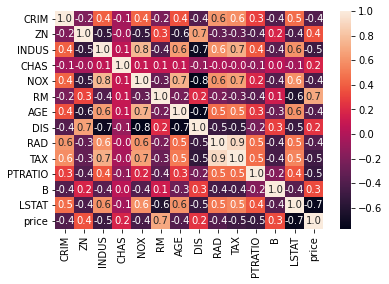

In [6]:
sns.heatmap(df.corr(), annot=True, fmt='.1f')

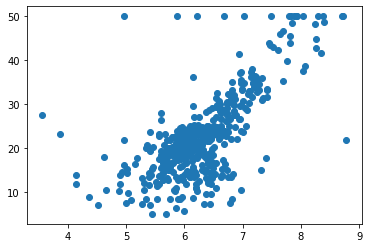

In [8]:
plt.scatter(df['RM'], df['price'])

### 早起人们预测未来的房价采用将历史的放假作为一个字典, 如果队友没有出现的RM房间，就采用KNN最邻近的平均值


In [11]:
room_to_price = {room: price for room, price in zip(df['RM'], df['price'])}

In [16]:
def knn(history_price, room, top_n):
    similar_price = sorted(history_price.items(), key=lambda x: (x[0] - room) ** 2)[:top_n]
    avg_price = np.mean([price for _, price in similar_price])
    return avg_price

knn(room_to_price, 7, 3)

29.233333333333334

### 为了更快的获得结果，我们希望通过拟合函数来获得预测能力
$$ f(rm) = k * rm + b $$
### Random Approach (蒙特卡洛模拟)
$$ Loss(k, b) = \frac{1}{n} \sum_{i \in N} (\hat{y_i} - y_i) ^ 2 $$
$$ Loss(k, b) = \frac{1}{n} \sum_{i \in N} ((k * rm_i + b) - y_i) ^ 2 $$

In [29]:
def loss(y_hat, y):
    return np.mean((y_hat - y) ** 2)

import random

def random_approach(X, y, iter=100):
    min_loss = float('inf')
    best_k, best_b = None, None
    for step in range(iter):
        min_v, max_v = -100, 100
        k, b = random.randrange(min_v, max_v), random.randrange(min_v, max_v)
        y_hats = [k * x + b for x in X]
        current_loss = loss(y_hats, y)
        if current_loss < min_loss:
            min_loss = current_loss
            best_k, best_b = k, b
            print(f'在第{step}步获得了函数f(x) = {best_k} * x + {best_b}， 此时的loss为{min_loss}')
    return best_k, best_b

random_approach(df['RM'], df['price'], 1000)

在第0步获得了函数f(x) = -45 * x + 64， 此时的loss为59731.3873007411
在第1步获得了函数f(x) = -38 * x + 72， 此时的loss为36989.7093009249
在第2步获得了函数f(x) = -27 * x + 72， 此时的loss为15138.112751903162
在第4步获得了函数f(x) = 17 * x + -96， 此时的loss为211.0833892944664
在第213步获得了函数f(x) = -1 * x + 36， 此时的loss为145.47054040909092
在第434步获得了函数f(x) = -2 * x + 41， 此时的loss为139.11411736758893
在第476步获得了函数f(x) = 11 * x + -37， 此时的loss为137.50013969762847
在第533步获得了函数f(x) = 18 * x + -94， 此时的loss为94.2323684347826
在第816步获得了函数f(x) = 11 * x + -47， 此时的loss为45.53670096245059


(11, -47)

### 蒙特卡洛模拟采用随机的方法，稳定性太差, 利用梯度下降的方式使x朝着梯度的方向变化，从而减少loss
### Supervisor
$$ Loss(k, b) = \frac{1}{n} \sum_{i \in N} ((k * rm_i + b) - y_i) ^ 2 $$
$$ \frac{\partial{loss(k, b)}}{\partial{k}} = \frac{2}{n}\sum_{i \in N}(k * rm_i + b - y_i) * rm_i $$
$$ \frac{\partial{loss(k, b)}}{\partial{b}} = \frac{2}{n}\sum_{i \in N}(k * rm_i + b - y_i)$$

In [24]:
def partial_k(k, b, x, y):
    return 2 * np.mean((k * x + b - y) * x)

def partial_b(k, b, x, y):
    return 2 * np.mean(k * x + b - y)

def gradient_descent(X, y, learning_rate= 1e-2, iter=2000):
    k, b = random.random(), random.random()
    min_loss = float('inf')
    best_k, best_b = None, None
    for step in range(iter):
        k += (-1) * partial_k(k, b, X, y) * learning_rate
        b += (-1) * partial_b(k, b, X, y) * learning_rate
        y_hats = k * X + b
        current_loss = loss(y_hats, y)
        if current_loss < min_loss:
            min_loss = current_loss
            best_k, best_b = k, b
            print(f'在第{step}步获得了函数f(x) = {best_k} * x + {best_b}， 此时的loss为{min_loss}')
    return best_k, best_b

best_k, best_b = gradient_descent(df['RM'], df['price'])

在第0步获得了函数f(x) = 2.84695483543015 * x + 0.7602779046866238， 此时的loss为77.93617006942787
在第1步获得了函数f(x) = 3.39633774190706 * x + 0.7688336537981088， 此时的loss为59.8164064438129
在第2步获得了函数f(x) = 3.5052562257595556 * x + 0.7635280309466118， 此时的loss为59.101698817773936
在第3步获得了函数f(x) = 3.5277300554966646 * x + 0.7555037244885182， 此时的loss为59.06501448461443
在第4步获得了函数f(x) = 3.5332382164330824 * x + 0.7469475686069449， 此时的loss为59.0559461979669
在第5步获得了函数f(x) = 3.5354164708864597 * x + 0.7382887451861612， 此时的loss为59.04823891268632
在第6步获得了函数f(x) = 3.536940937640424 * x + 0.7296114839101063， 此时的loss为59.040645256481625
在第7步获得了函数f(x) = 3.5383368247691713 * x + 0.7209323150545689， 此时的loss为59.03307085639775
在第8步获得了函数f(x) = 3.5397072082888856 * x + 0.712254482388305， 此时的loss为59.025502986091816
在第9步获得了函数f(x) = 3.5410723176923473 * x + 0.7035786221053766， 此时的loss为59.01793937016372
在第10步获得了函数f(x) = 3.5424361232323296 * x + 0.6949048586442221， 此时的loss为59.010379569289356
在第11步获得了函数f(x) = 3.5437994041660663 * x + 0.68

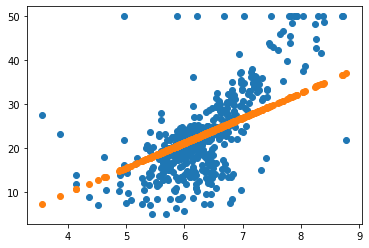

In [28]:
plt.scatter(df['RM'], df['price'])
plt.scatter(df['RM'], [best_k * x + best_b for x in df['RM']])

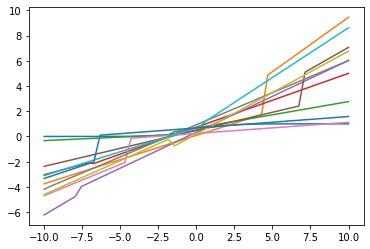

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def random_linear(x):
    k, b = random.random(), random.random()
    return k * x + b

def complex_function(x):
    return random_linear(x)

sub_x = np.linspace(-10, 10)
plt.plot(sub_x, sigmoid(sub_x))

for _ in range(10):
    index = random.randrange(0, len(sub_x))
    sub_x_1, sub_x_2 = sub_x[: index], sub_x[index: ]
    new_y = np.concatenate((complex_function(sub_x_1), complex_function(sub_x_2)))
    plt.plot(sub_x, new_y)

### 1. 什么是机器学习
### 2. KNN这种方法的缺陷，提出线性拟合的背景是什么
### 3. 怎么样通过监督的方法，来获得更快的函数权值更新
### 4. 非线性函数和线性函数的结合，可以拟合出非常复杂的函数
### 5. 深度学习我们可以通过基本的函数模块，来拟合更加复杂的函数